In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy   as np
import xgboost as xgb

In [ ]:
original_ds = pd.read_csv("chicago_listings.csv")

room_type_dict = sorted(original_ds["room_type"].unique().tolist()+["other"])
room_cat = pd.CategoricalDtype(categories=room_type_dict)

neighbourhood_dict = sorted(original_ds["neighbourhood"].unique().tolist()+["other"])
neigh_cat = pd.CategoricalDtype(categories=neighbourhood_dict)

In [ ]:
over_priced = np.quantile(original_ds.price,.99)
over_priced

1010.0

In [ ]:
train_pd = pd.read_csv("train_1.csv")
#train_pd["over_price"] = 0
#over_priced = np.quantile(train_pd.price,.99)
#train_pd.loc[train_pd.price<over_priced,"over_price"] = 1
#train_pd = train_pd[train_pd.price<over_priced]
X_train = train_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]
#X_train = train_pd[["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month"]]


train_pd.room_type = train_pd.room_type.astype(room_cat)
X_train = pd.concat([X_train,pd.get_dummies(train_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True)],axis=1)
train_pd.neighbourhood = train_pd.neighbourhood.astype(neigh_cat)
X_train = pd.concat([X_train,pd.get_dummies(train_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)
y_train = train_pd[["price"]]

In [ ]:
train_pd.shape

(3050, 18)

In [ ]:
train_pd[["price"]].describe()

,price
count,3050.000000
mean,175.367541
std,312.439731
min,15.000000
25%,73.250000
50%,120.000000
75%,187.000000
max,10000.000000


In [ ]:
train_pd[["number_of_reviews","reviews_per_month"]]

,number_of_reviews,reviews_per_month
0,475,2.90
1,342,2.94
2,171,1.67
3,205,1.76
4,118,1.04
...,...,...
3045,0,NaN
3046,0,NaN
3047,0,NaN
3048,0,NaN


In [ ]:
y_train

,price
0,85
1,214
2,75
3,120
4,103
...,...
3045,87
3046,46
3047,72
3048,66


XGBoost model on the raw dataset without treatments

In [ ]:
!ls *.csv

airbnb_sample1_a.csv
airbnb_sample2_a.csv
chicago_listings.csv
chicago_vert_1_a.csv
chicago_vert_1.csv
chicago_vert_2_a.csv
chicago_vert_2.csv
chicago_vert_dataset_cleaned_1_baseline.csv
chicago_vert_dataset_cleaned_1.csv
chicago_vert_dataset_cleaned_2_baseline.csv
chicago_vert_dataset_cleaned_2.csv
chicago_vert_dataset_cleaned_3.csv
chicago_vert_dataset_cleaned_baseline_avg_1.csv
chicago_vert_dataset_cleaned_baseline_avg_2.csv
chicago_vert_dataset_cleaned_whole_c1.csv
chicago_vert_dataset_cleaned_whole_c2.csv
chicago_vert_dataset_cleaned_whole_c3.csv
chicago_vert_dataset_cleaned_whole_merging.csv
comparison_table_whole_c1.csv
comparison_table_whole_c2.csv
comparison_table_whole_c3.csv
comparison_table_whole_merging.csv
compiled_results_split_all.csv
completeness_accuracy_cleaned.csv
test_1.csv
test_remove_all_noise.csv
train_1.csv
train_all.csv
train_remove_all_noise_1.csv
train_remove_all_noise.csv
val_remove_all_noise.csv


In [ ]:
test_pd = pd.read_csv("test_1.csv")
#test_pd = test_pd.append(pd.read_csv("val_remove_all_noise.csv"))
#test_pd["over_price"] = 0
#test_pd.loc[test_pd.price<over_priced,"over_price"] = 1
test_pd = test_pd[test_pd.price<over_priced]
X_test = test_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]
#X_test = test_pd[["latitude","longitude","minimum_nights","number_of_reviews","reviews_per_month"]]
#X_test = pd.DataFrame()


room_cat = pd.CategoricalDtype(categories=room_type_dict)
test_pd.room_type = test_pd.room_type.astype(room_cat)
X_test =pd.concat([X_test,pd.get_dummies(test_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True,)],axis=1)
neigh_cat = pd.CategoricalDtype(categories=neighbourhood_dict)
test_pd.neighbourhood = test_pd.neighbourhood.astype(neigh_cat)
X_test = pd.concat([X_test,pd.get_dummies(test_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)

y_test = test_pd[["price"]]

In [ ]:
test_pd[["price"]].describe()

,price
count,4532.000000
mean,153.741395
std,133.216154
min,0.000000
25%,73.000000
50%,119.500000
75%,182.000000
max,1000.000000


In [ ]:
#regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                           n_estimators  = search.best_params_["n_estimators"],
#                           max_depth     = search.best_params_["max_depth"],
#                           eval_metric='rmsle')


regressor=xgb.XGBRegressor(learning_rate = 0.005,
                           n_estimators  = 500,
                           max_depth     = 7,
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds:
# "Validation metric needs to improve at least once in every
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

In [ ]:
#predictions[predictions<0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error,mean_squared_error

RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
RMSE = np.sqrt( mean_squared_error(y_test, predictions) )

print("The score is %.5f" % RMSLE )
print("The score is %.5f" % RMSE )

The score is 0.62483
The score is 212.58181


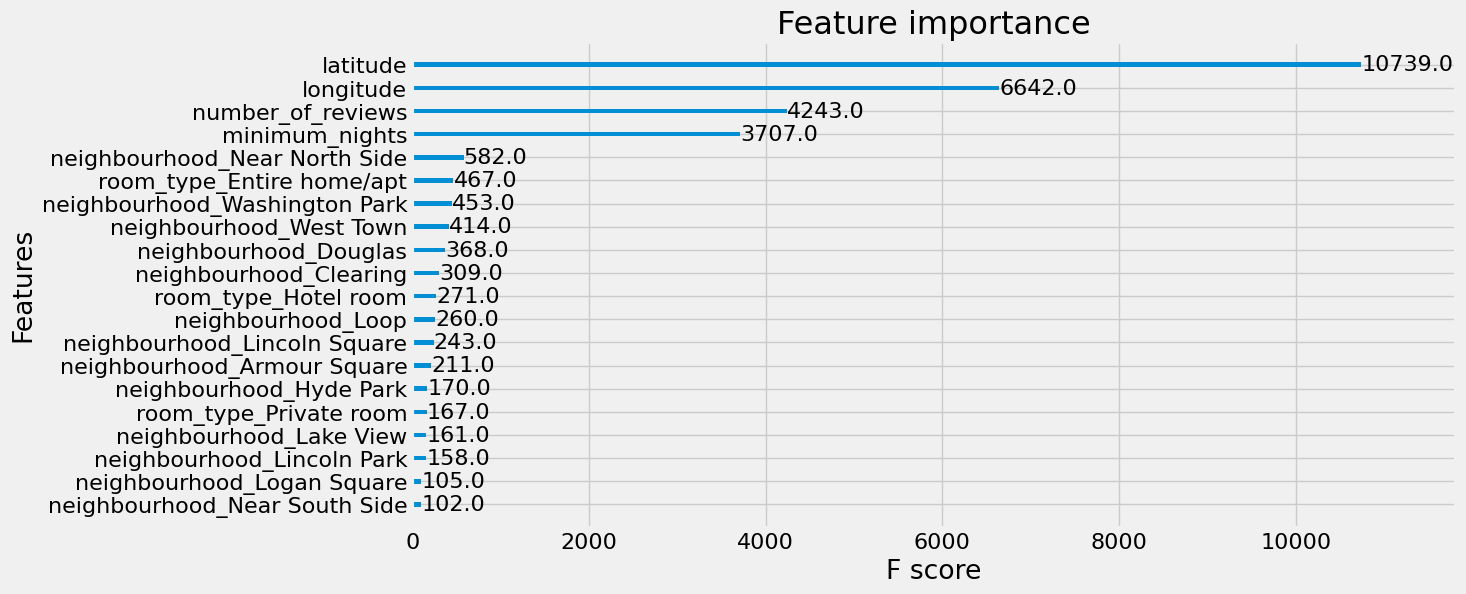

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

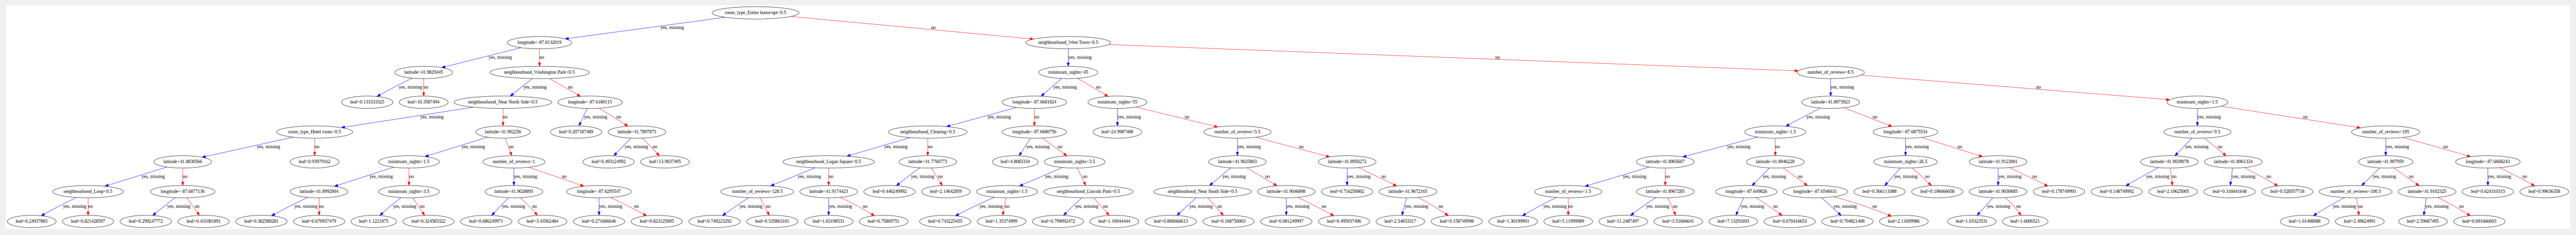

In [ ]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(50,50))
plot_tree(regressor,ax=ax)
plt.show()

# running without any treatment

In [ ]:
!wc -l train_remove_all_noise*.csv
!wc -l train_all.csv

  1605 train_remove_all_noise_1.csv
  2889 train_remove_all_noise.csv
  4494 total
6500 train_all.csv


In [ ]:
train_pd = pd.read_csv("chicago_vert_dataset_cleaned_1_baseline.csv")
train_pd = train_pd.append(pd.read_csv("chicago_vert_dataset_cleaned_2_baseline.csv"))

train_pd = train_pd[(train_pd.id_flag==0)&
          (train_pd.neighbourhood_flag==0)&(train_pd.latitude_flag==0)&
         (train_pd.longitude_flag==0)&(train_pd.minimum_nights_flag==0)&
         (train_pd.number_of_reviews_flag==0)&
         (train_pd.room_type_flag==0)
         ]

<ipython-input-25-85ba8dce3e43>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_pd = train_pd.append(pd.read_csv("chicago_vert_dataset_cleaned_2_baseline.csv"))


In [ ]:
train_pd.shape

(1762, 28)

In [ ]:
#train_pd = train_pd[train_pd.price<over_priced]
#train_pd["over_price"] = 0
#over_priced = np.quantile(train_pd.price,.99)
#train_pd.loc[train_pd.price<over_priced,"over_price"] = 1
#train_pd = train_pd[train_pd.price<over_priced]
train_pd["latitude"] = train_pd.latitude.astype(float)
train_pd["longitude"] = train_pd.longitude.astype(float)
train_pd["number_of_reviews"] = train_pd.number_of_reviews.astype(int)
train_pd["minimum_nights"] = train_pd.minimum_nights.astype(int)
train_pd["reviews_per_month"] = train_pd.reviews_per_month.astype(float)

X_train = train_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]
#X_train = pd.DataFrame()
room_type_dict = sorted(original_ds["room_type"].unique().tolist())

train_pd.room_type = train_pd.room_type.astype(room_cat)
X_train = pd.concat([X_train,pd.get_dummies(train_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True)],axis=1)
neighbourhood_dict = sorted(original_ds["neighbourhood"].unique().tolist())
train_pd.neighbourhood = train_pd.neighbourhood.astype(neigh_cat)
X_train = pd.concat([X_train,pd.get_dummies(train_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)
y_train = train_pd[["price"]]

In [ ]:
train_pd.shape

(1762, 28)

In [ ]:

#regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                           n_estimators  = search.best_params_["n_estimators"],
#                           max_depth     = search.best_params_["max_depth"],
#                           eval_metric='rmsle')

regressor=xgb.XGBRegressor(learning_rate = 0.005,
                           n_estimators  = 500,
                           max_depth     = 7,
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds:
# "Validation metric needs to improve at least once in every
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

In [ ]:
predictions[predictions<0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
RMSE = np.sqrt( mean_squared_error(y_test, predictions) )

print("The score is %.5f" % RMSLE )
print("The score is %.5f" % RMSE )

The score is 0.67974
The score is 362.05015


In [ ]:
test_frame = pd.DataFrame({"y":y_test.price.values,"pred":predictions})
test_frame["delta"] = test_frame.apply(lambda x:x.y-x.pred,axis=1)
test_frame.sort_values("delta",ascending=False).head(20)
test_frame.sort_values("delta",ascending=False).tail(20)

,y,pred,delta
2568,100,1438.330322,-1338.330322
4197,188,1684.923706,-1496.923706
4150,119,1639.775635,-1520.775635
4342,227,1935.331909,-1708.331909
3264,100,2474.606445,-2374.606445
4341,202,2874.620361,-2672.620361
1855,45,3965.141113,-3920.141113
1839,42,3965.141113,-3923.141113
1856,39,3965.141113,-3926.141113
1835,39,3965.141113,-3926.141113


<Axes: >

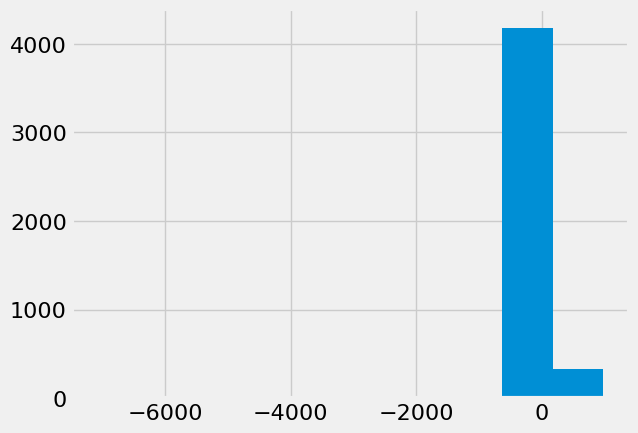

In [ ]:
test_frame.delta.hist()

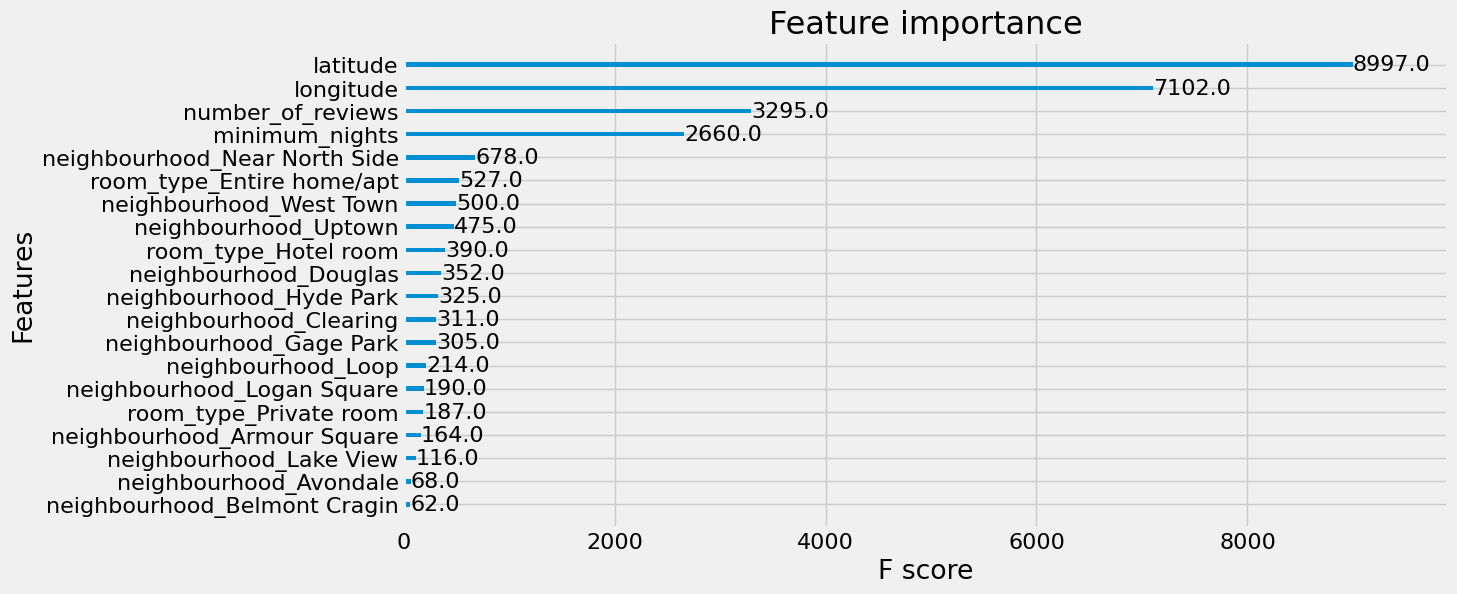

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

Baseline 2: Averaging

In [ ]:
train_pd = pd.read_csv("chicago_vert_dataset_cleaned_baseline_avg_1.csv")
train_pd = train_pd.append(pd.read_csv("chicago_vert_dataset_cleaned_baseline_avg_2.csv"))

train_pd = train_pd[(train_pd.id_flag==0)&
          (train_pd.neighbourhood_flag==0)&(train_pd.latitude_flag==0)&
         (train_pd.longitude_flag==0)&(train_pd.minimum_nights_flag==0)&
         (train_pd.number_of_reviews_flag==0)&
         (train_pd.room_type_flag==0)
         ]

<ipython-input-35-af3a0c3567ba>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_pd = train_pd.append(pd.read_csv("chicago_vert_dataset_cleaned_baseline_avg_2.csv"))


In [ ]:
train_pd = train_pd[train_pd.price.isna()==False]

In [ ]:
train_pd.shape

(3042, 28)

In [ ]:
#train_pd = train_pd[train_pd.price<over_priced]
#train_pd["over_price"] = 0
#over_priced = np.quantile(train_pd.price,.99)
#train_pd.loc[train_pd.price<over_priced,"over_price"] = 1
#train_pd = train_pd[train_pd.price<over_priced]
train_pd["latitude"] = train_pd.latitude.fillna(0)
train_pd["longitude"] = train_pd.longitude.fillna(0)
train_pd["latitude"] = train_pd.latitude.astype(float)
train_pd["longitude"] = train_pd.longitude.astype(float)
train_pd["number_of_reviews"] = train_pd.number_of_reviews.fillna(0)
train_pd["number_of_reviews"] = train_pd.number_of_reviews.astype(int)
train_pd["minimum_nights"] = train_pd.minimum_nights.fillna(0)
train_pd["minimum_nights"] = train_pd.minimum_nights.astype(int)
train_pd["reviews_per_month"] = train_pd.reviews_per_month.fillna(0)
train_pd["reviews_per_month"] = train_pd.reviews_per_month.astype(float)

X_train = train_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]
#X_train = pd.DataFrame()
room_type_dict = sorted(original_ds["room_type"].unique().tolist())

train_pd.room_type = train_pd.room_type.astype(room_cat)
X_train = pd.concat([X_train,pd.get_dummies(train_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True)],axis=1)
neighbourhood_dict = sorted(original_ds["neighbourhood"].unique().tolist())
train_pd.neighbourhood = train_pd.neighbourhood.astype(neigh_cat)
X_train = pd.concat([X_train,pd.get_dummies(train_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)
X_train = X_train.fillna(0)
y_train = train_pd[["price"]]

<ipython-input-38-4afbc7ed2c5a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_pd["latitude"] = train_pd.latitude.fillna(0)
<ipython-input-38-4afbc7ed2c5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_pd["longitude"] = train_pd.longitude.fillna(0)
<ipython-input-38-4afbc7ed2c5a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
y_train[y_train.price.isna()]

,price


In [ ]:
train_pd.shape

(3042, 28)

In [ ]:

#regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                           n_estimators  = search.best_params_["n_estimators"],
#                           max_depth     = search.best_params_["max_depth"],
#                           eval_metric='rmsle')

regressor=xgb.XGBRegressor(learning_rate = 0.005,
                           n_estimators  = 500,
                           max_depth     = 7,
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds:
# "Validation metric needs to improve at least once in every
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

In [ ]:
predictions[predictions<0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
RMSE = np.sqrt( mean_squared_error(y_test, predictions) )

print("The score is %.5f" % RMSLE )
print("The score is %.5f" % RMSE )

The score is 0.63146
The score is 207.41814


In [ ]:
test_frame = pd.DataFrame({"y":y_test.price.values,"pred":predictions})
test_frame["delta"] = test_frame.apply(lambda x:x.y-x.pred,axis=1)
test_frame.sort_values("delta",ascending=False).head(20)
test_frame.sort_values("delta",ascending=False).tail(20)

,y,pred,delta
4116,140,454.858582,-314.858582
3003,24,340.941772,-316.941772
214,99,416.537048,-317.537048
1956,28,353.882874,-325.882874
1593,73,404.206055,-331.206055
4524,217,551.492065,-334.492065
104,237,748.066772,-511.066772
4369,533,1196.839111,-663.839111
1638,70,787.900879,-717.900879
3893,336,1116.557251,-780.557251


<Axes: >

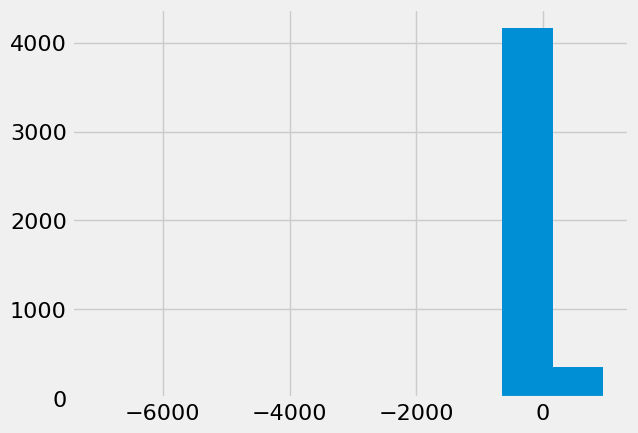

In [ ]:
test_frame.delta.hist()

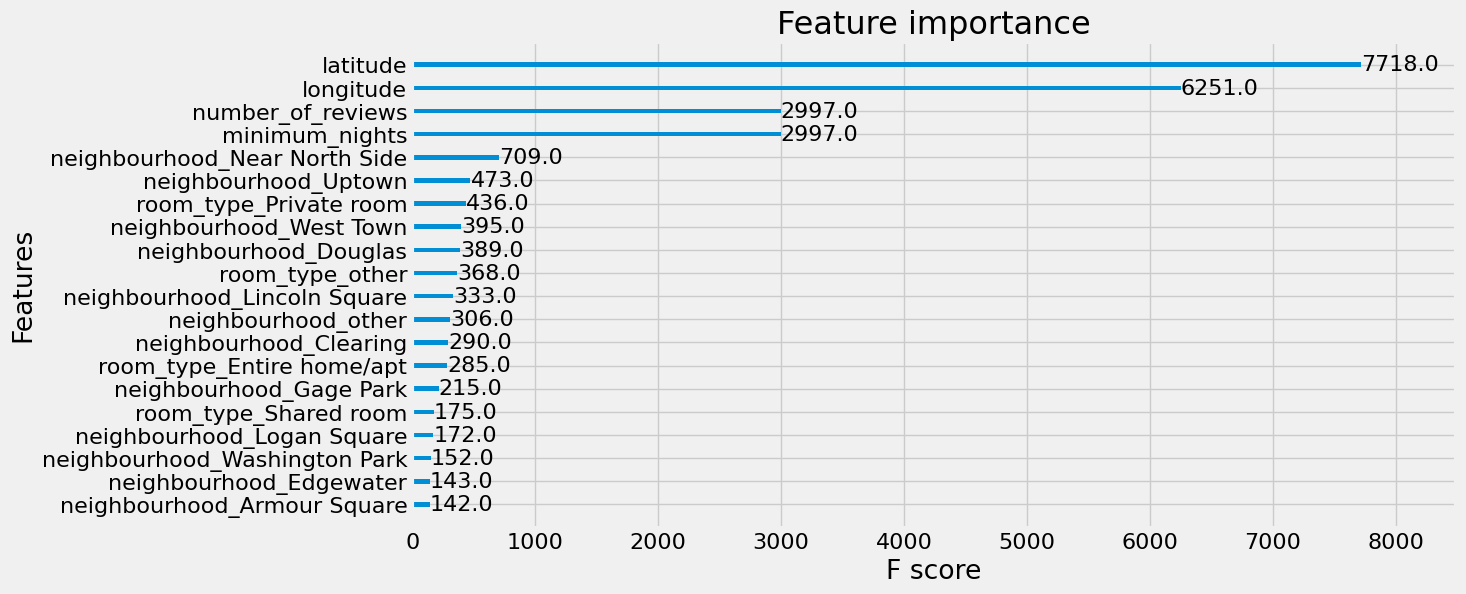

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

# performance from horizontal split

In [ ]:
!ls -ltr chicago_vert_dataset_cleaned_1* ; date

-rw------- 1 root root 277390 Apr  4 02:25 chicago_vert_dataset_cleaned_1_baseline.csv
-rw------- 1 root root 277114 Apr  5 01:16 chicago_vert_dataset_cleaned_1.csv
Sun 07 May 2023 11:10:10 PM UTC


In [ ]:
vert_1 = pd.read_csv("chicago_vert_dataset_cleaned_1.csv")
vert_2 = pd.read_csv("chicago_vert_dataset_cleaned_2.csv")

vert_clean_pd = vert_1.copy()
vert_clean_pd["group"] = 1
temp = vert_2.copy()
temp["group"] = 2
vert_clean_pd = vert_clean_pd.append(temp)

<ipython-input-48-bebfcd85b828>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vert_clean_pd = vert_clean_pd.append(temp)


In [ ]:
vert_1.shape,vert_2.shape,vert_clean_pd.shape

((1486, 28), (1715, 28), (3201, 29))

In [ ]:
vert_clean_pd = vert_clean_pd[(vert_clean_pd.id_flag==0)&
          (vert_clean_pd.neighbourhood_flag==0)&(vert_clean_pd.latitude_flag==0)&
         (vert_clean_pd.longitude_flag==0)&(vert_clean_pd.minimum_nights_flag==0)&
         (vert_clean_pd.number_of_reviews_flag==0)&
         (vert_clean_pd.room_type_flag==0)
         ]

In [ ]:
vert_clean_pd.shape

(2846, 29)

In [ ]:
vert_clean_pd.groupby("group").count()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,...,license,id_flag,host_id_flag,neighbourhood_flag,latitude_flag,longitude_flag,minimum_nights_flag,number_of_reviews_flag,last_review_flag,room_type_flag
group,,,,,,,,,,,,,,,,,,,,,
1,1408,1408,1407,1408,1408,0,1408,1408,1408,1408,...,1219,1408,1408,1408,1408,1408,1408,1408,1408,1408
2,1438,1438,1438,1438,1438,0,1438,1438,1438,1438,...,1226,1438,1438,1438,1438,1438,1438,1438,1438,1438


In [ ]:
#vert_clean_pd["over_price"] = 0
#over_priced = np.q[uantile(vert_clean_pd.price,.99)
vert_clean_pd = vert_clean_pd.fillna(0)
#vert_clean_pd = vert_clean_pd[vert_clean_pd.price<over_priced]
#vert_clean_pd.loc[vert_clean_pd.price<over_priced,"over_price"] = 1
vert_clean_pd["latitude"] = vert_clean_pd.latitude.astype(float)
vert_clean_pd["longitude"] = vert_clean_pd.longitude.astype(float)
vert_clean_pd["number_of_reviews"] = vert_clean_pd.number_of_reviews.astype(int)
vert_clean_pd["minimum_nights"] = vert_clean_pd.minimum_nights.astype(int)
vert_clean_pd["reviews_per_month"] = vert_clean_pd.reviews_per_month.astype(float)

X_train = vert_clean_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]

#X_train = pd.DataFrame()
room_type_dict = sorted(original_ds["room_type"].unique().tolist())
vert_clean_pd.room_type = vert_clean_pd.room_type.astype(room_cat)
X_train = pd.concat([X_train,pd.get_dummies(vert_clean_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True)],axis=1)
neighbourhood_dict = sorted(original_ds["neighbourhood"].unique().tolist())
vert_clean_pd.neighbourhood = vert_clean_pd.neighbourhood.astype(neigh_cat)
X_train = pd.concat([X_train,pd.get_dummies(vert_clean_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)
y_train = vert_clean_pd[["price"]]

In [ ]:
#regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                           n_estimators  = search.best_params_["n_estimators"],
#                           max_depth     = search.best_params_["max_depth"],
#                           eval_metric='rmsle')


regressor=xgb.XGBRegressor(learning_rate = 0.005,
                           n_estimators  = 500,
                           max_depth     = 7,
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds:
# "Validation metric needs to improve at least once in every
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
RMSE = np.sqrt( mean_squared_error(y_test, predictions) )

print("The score is %.5f" % RMSLE )
print("The score is %.5f" % RMSE )

The score is 0.63251
The score is 214.41985


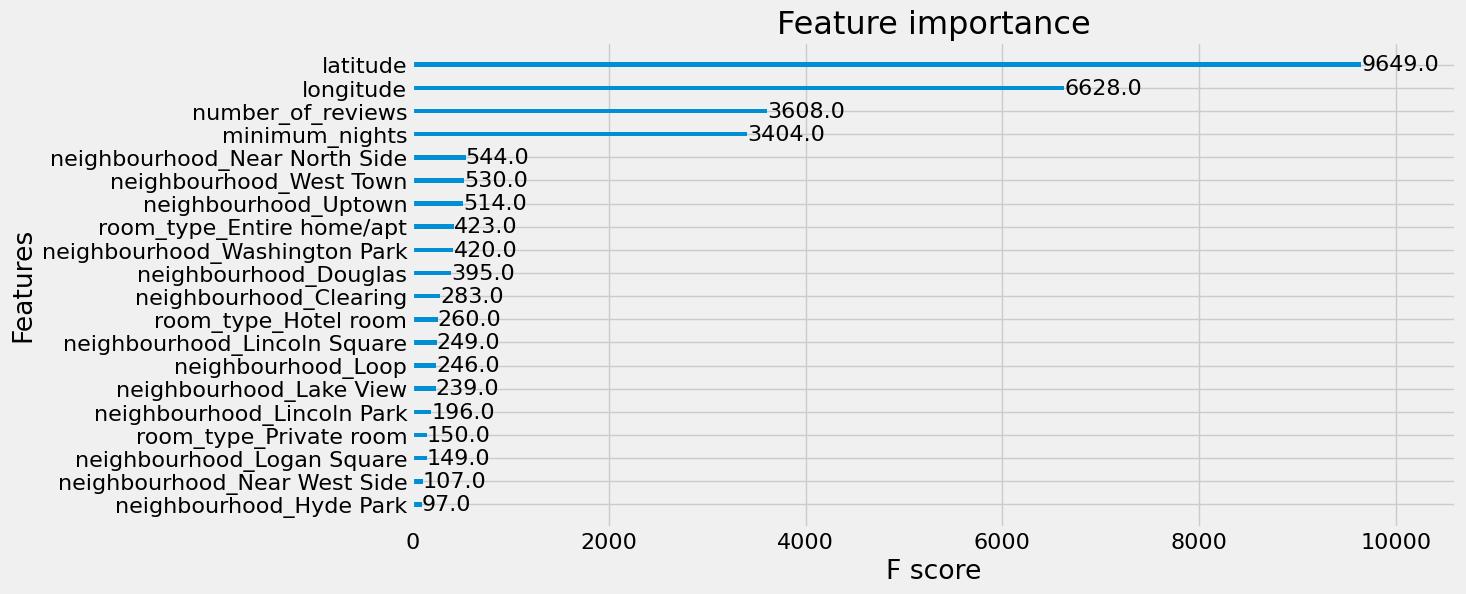

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

# Horizontal Colaboration

In [ ]:
# Horizontal Cleaning

In [ ]:
vert_1 = pd.read_csv("chicago_vert_dataset_cleaned_1.csv")
vert_2 = pd.read_csv("chicago_vert_dataset_cleaned_2.csv")
vert_3 = pd.read_csv("chicago_vert_dataset_cleaned_3.csv")

vert_2["latitude"] = vert_3["latitude"]
vert_2["latitude_flag"] = vert_3["latitude_flag"]
vert_2["longitude"] = vert_3["longitude"]
vert_2["longitude_flag"] = vert_3["longitude_flag"]
vert_2["room_type"] = vert_3["room_type"]
vert_2["room_type_flag"] = vert_3["room_type_flag"]

vert_clean_pd = vert_1.copy()
vert_clean_pd["group"] = 1
temp = vert_2.copy()
temp["group"] = 2
vert_clean_pd = vert_clean_pd.append(temp)

<ipython-input-58-b078fdafa11e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vert_clean_pd = vert_clean_pd.append(temp)


In [ ]:
vert_1.shape,vert_2.shape,vert_clean_pd.shape

((1486, 28), (1715, 28), (3201, 29))

In [ ]:
vert_clean_pd = vert_clean_pd[(vert_clean_pd.id_flag==0)&
          (vert_clean_pd.neighbourhood_flag==0)&(vert_clean_pd.latitude_flag==0)&
         (vert_clean_pd.longitude_flag==0)&(vert_clean_pd.minimum_nights_flag==0)&
         (vert_clean_pd.number_of_reviews_flag==0)&
         (vert_clean_pd.room_type_flag==0)
         ]

In [ ]:
vert_clean_pd.shape

(3038, 29)

In [ ]:
vert_clean_pd.groupby("group").count()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,...,license,id_flag,host_id_flag,neighbourhood_flag,latitude_flag,longitude_flag,minimum_nights_flag,number_of_reviews_flag,last_review_flag,room_type_flag
group,,,,,,,,,,,,,,,,,,,,,
1,1408,1408,1407,1408,1408,0,1408,1408,1408,1408,...,1219,1408,1408,1408,1408,1408,1408,1408,1408,1408
2,1630,1630,1630,1630,1630,0,1630,1630,1630,1630,...,1381,1630,1630,1630,1630,1630,1630,1630,1630,1630


In [ ]:
#vert_clean_pd["over_price"] = 0
#over_priced = np.q[uantile(vert_clean_pd.price,.99)
vert_clean_pd = vert_clean_pd.fillna(0)
#vert_clean_pd = vert_clean_pd[vert_clean_pd.price<over_priced]
#vert_clean_pd.loc[vert_clean_pd.price<over_priced,"over_price"] = 1
vert_clean_pd["latitude"] = vert_clean_pd.latitude.astype(float)
vert_clean_pd["longitude"] = vert_clean_pd.longitude.astype(float)
vert_clean_pd["number_of_reviews"] = vert_clean_pd.number_of_reviews.astype(int)
vert_clean_pd["minimum_nights"] = vert_clean_pd.minimum_nights.astype(int)
vert_clean_pd["reviews_per_month"] = vert_clean_pd.reviews_per_month.astype(float)

X_train = vert_clean_pd[["latitude","longitude","minimum_nights","number_of_reviews"]]

#X_train = pd.DataFrame()
room_type_dict = sorted(original_ds["room_type"].unique().tolist())
vert_clean_pd.room_type = vert_clean_pd.room_type.astype(room_cat)
X_train = pd.concat([X_train,pd.get_dummies(vert_clean_pd.room_type,columns=room_type_dict,prefix="room_type",dummy_na=True)],axis=1)
neighbourhood_dict = sorted(original_ds["neighbourhood"].unique().tolist())
vert_clean_pd.neighbourhood = vert_clean_pd.neighbourhood.astype(neigh_cat)
X_train = pd.concat([X_train,pd.get_dummies(vert_clean_pd.neighbourhood,columns=neighbourhood_dict,prefix="neighbourhood",dummy_na=True)],axis=1)
y_train = vert_clean_pd[["price"]]

In [ ]:
#regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                           n_estimators  = search.best_params_["n_estimators"],
#                           max_depth     = search.best_params_["max_depth"],
#                           eval_metric='rmsle')


regressor=xgb.XGBRegressor(learning_rate = 0.005,
                           n_estimators  = 500,
                           max_depth     = 7,
                           eval_metric='rmsle')

regressor.fit(X_train, y_train)

#=========================================================================
# To use early_stopping_rounds:
# "Validation metric needs to improve at least once in every
# early_stopping_rounds round(s) to continue training."
#=========================================================================
# first perform a test/train split
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
#regressor.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

#=========================================================================
# use the model to predict the prices for the test data
#=========================================================================
predictions = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
RMSE = np.sqrt( mean_squared_error(y_test, predictions) )

print("The score is %.5f" % RMSLE )
print("The score is %.5f" % RMSE )

The score is 0.62528
The score is 212.54806


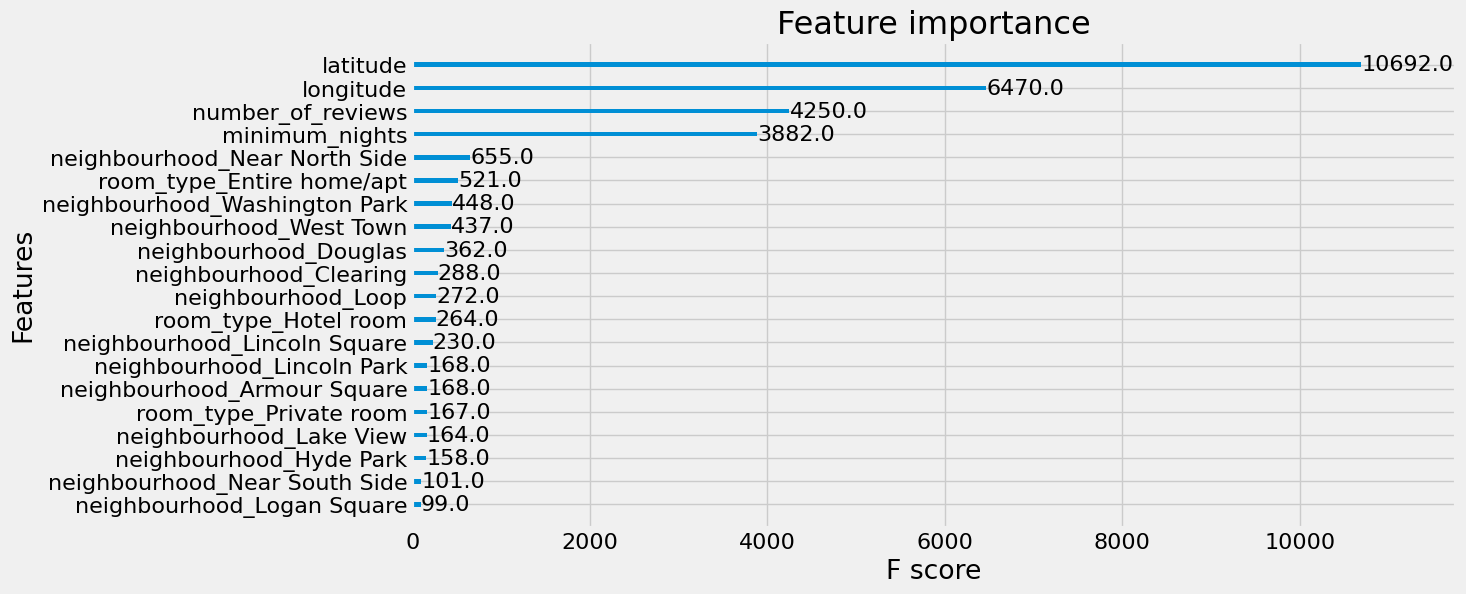

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

# analysis correctness for cleaning

In [ ]:
orig_vert = pd.read_csv("airbnb_sample1_a.csv")
orig_vert = orig_vert.append(pd.read_csv("airbnb_sample2_a.csv"))

<ipython-input-67-400557dcc346>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  orig_vert = orig_vert.append(pd.read_csv("airbnb_sample2_a.csv"))


In [ ]:
pertubed_vert = pd.read_csv("chicago_vert_1_a.csv")
pertubed_vert = pertubed_vert.append(pd.read_csv("chicago_vert_2_a.csv"))

<ipython-input-68-3dd58ec89c80>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pertubed_vert = pertubed_vert.append(pd.read_csv("chicago_vert_2_a.csv"))


In [ ]:
orig_vert.shape,pertubed_vert.shape

((3050, 18), (3201, 27))

In [ ]:
!ls -ltr chicago_vert_dataset_cleaned_*.csv

-rw------- 1 root root 277390 Apr  4 02:25 chicago_vert_dataset_cleaned_1_baseline.csv
-rw------- 1 root root 323268 Apr  4 02:25 chicago_vert_dataset_cleaned_2_baseline.csv
-rw------- 1 root root 322030 Apr  5 01:04 chicago_vert_dataset_cleaned_2.csv
-rw------- 1 root root 277114 Apr  5 01:16 chicago_vert_dataset_cleaned_1.csv
-rw------- 1 root root 324355 Apr  5 13:56 chicago_vert_dataset_cleaned_3.csv
-rw------- 1 root root 619202 Apr  6 00:10 chicago_vert_dataset_cleaned_whole_c1.csv
-rw------- 1 root root 621232 Apr  6 00:54 chicago_vert_dataset_cleaned_whole_c2.csv
-rw------- 1 root root 621563 Apr  6 01:03 chicago_vert_dataset_cleaned_whole_c3.csv
-rw------- 1 root root 621734 Apr  6 03:04 chicago_vert_dataset_cleaned_whole_merging.csv
-rw------- 1 root root 275726 Apr 18 16:07 chicago_vert_dataset_cleaned_baseline_avg_1.csv
-rw------- 1 root root 320178 Apr 18 16:08 chicago_vert_dataset_cleaned_baseline_avg_2.csv


In [ ]:
vert_1 = pd.read_csv("chicago_vert_dataset_cleaned_1.csv")
vert_2 = pd.read_csv("chicago_vert_dataset_cleaned_2.csv")

vert_clean_pd = vert_1.copy()
vert_clean_pd["group"] = 1
temp = vert_2.copy()
temp["group"] = 2
vert_clean_pd = vert_clean_pd.append(temp)

<ipython-input-147-bebfcd85b828>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vert_clean_pd = vert_clean_pd.append(temp)


In [ ]:
vert_3 = pd.read_csv("chicago_vert_dataset_cleaned_3.csv")

In [ ]:
vert_3.latitude_flag

0       0
1       0
2       0
3       0
4       0
       ..
1710    0
1711    0
1712    0
1713    0
1714    0
Name: latitude_flag, Length: 1715, dtype: int64

In [ ]:
vert_2["latitude"] = vert_3["latitude"]
vert_2["latitude_flag"] = vert_3["latitude_flag"]
vert_2["longitude"] = vert_3["longitude"]
vert_2["longitude_flag"] = vert_3["longitude_flag"]
vert_2["room_type"] = vert_3["room_type"]
vert_2["room_type_flag"] = vert_3["room_type_flag"]

In [ ]:
vert_clean_pd = vert_1.copy()
vert_clean_pd["group"] = 1
temp = vert_2.copy()
temp["group"] = 2
vert_clean_pd = vert_clean_pd.append(temp)

<ipython-input-151-143aa6152a47>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vert_clean_pd = vert_clean_pd.append(temp)


In [ ]:
!ls -ltr

total 12543
-rw------- 1 root root 1247063 Mar 20 22:24  chicago_listings.csv
-rw------- 1 root root   56463 Apr  1 23:40  val_remove_all_noise.csv
-rw------- 1 root root  470607 Apr  1 23:40  train_remove_all_noise.csv
-rw------- 1 root root 1060160 Apr  1 23:40  train_all.csv
-rw------- 1 root root  130664 Apr  1 23:40  test_remove_all_noise.csv
-rw------- 1 root root  545201 Apr  1 23:43  chicago_vert_1.csv
-rw------- 1 root root  687444 Apr  1 23:44  chicago_vert_2.csv
-rw------- 1 root root  361111 Apr  2 00:41  RunningAnalysis.ipynb
-rw------- 1 root root  498598 Apr  2 07:19  train_1.csv
-rw------- 1 root root  748453 Apr  2 07:19  test_1.csv
-rw------- 1 root root  229957 Apr  2 07:32  airbnb_sample1_a.csv
-rw------- 1 root root  268877 Apr  2 07:32  airbnb_sample2_a.csv
-rw------- 1 root root  312002 Apr  2 07:34  chicago_vert_2_a.csv
-rw------- 1 root root  268113 Apr  2 07:35  chicago_vert_1_a.csv
-rw------- 1 root root  277808 Apr  2 07:37  train_remove_all_noise_1.csv
-rw-

In [ ]:
vert_clean_pd = pd.read_csv("chicago_vert_dataset_cleaned_whole_c1.csv")

In [ ]:
total_rows = orig_vert.shape[0]

In [ ]:
vert_clean_pd = vert_clean_pd[vert_clean_pd.id_flag==0].drop_duplicates("id")

In [ ]:
merge_set = orig_vert.merge(vert_clean_pd,left_on="id",right_on="id")

In [ ]:
# compare host_name
merge_set[merge_set.host_id_flag!=1].shape[0] / total_rows

0.7137704918032787

In [ ]:
temp_set = merge_set[(merge_set.id_flag!=1)&(merge_set.host_id_flag!=1)]
sum(temp_set["host_id_x"] == temp_set["host_id_y"])/total_rows

0.7137704918032787

In [ ]:
temp_set.shape

(2177, 47)

In [ ]:
temp_set.groupby("host_id_flag").count()[["id"]]

,id
host_id_flag,
0,2177


In [ ]:
temp_set.shape

(2177, 47)

In [ ]:
train_1 = pd.read_csv("train_1.csv")
train_1

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.902890,-87.681820,Entire home/apt,85,2,475,2022-12-05,2.90,1,325,45,R21000075737
1,1185749,3 Bdrm Vintage Hideaway Little Italy/ UIC,1664593,Matt & Christy,NaN,Near West Side,41.870860,-87.683050,Entire home/apt,214,32,342,2022-10-11,2.94,1,0,20,R22000081568
2,3434136,Beautiful West Lakeview location,17217012,Janet,NaN,Lake View,41.940200,-87.651330,Private room,75,2,171,2022-10-02,1.67,1,319,17,R17000013279
3,1195259,Wicker Park - Garden At The Heart of It All,2899484,Jason,NaN,West Town,41.910950,-87.677830,Entire home/apt,120,6,205,2022-11-18,1.76,2,363,11,R19000037818
4,1304049,Private room near UIC Medical Dist.,7089017,Sharon,NaN,Near West Side,41.871900,-87.684860,Private room,103,1,118,2022-10-15,1.04,1,363,8,R17000015307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3045,771066706846175423,Rustic 2BR Apartment in Lakeview,488113016,Alexis,NaN,Lake View,41.937990,-87.650910,Entire home/apt,87,1,0,NaN,NaN,8,84,0,R21000062397
3046,771838717940576502,Contemporary Cragin 1BR Apartment,488113016,Alexis,NaN,Belmont Cragin,41.930808,-87.758663,Entire home/apt,46,1,0,NaN,NaN,8,71,0,R22000093816
3047,771860062577897747,Comfy & Artistic 2BR Home in Francisco Ave,488113016,Alexis,NaN,West Ridge,41.996700,-87.701700,Entire home/apt,72,1,0,NaN,NaN,8,63,0,R21000062411
3048,771880753874742770,Spacious 2BR Stylish Apartment in Francisco Ave,488113016,Alexis,NaN,West Ridge,41.995330,-87.701640,Entire home/apt,66,1,0,NaN,NaN,8,70,0,R18000023286


In [ ]:
perturbed_1 = pd.read_csv("chicago_vert_1_a.csv").append(pd.read_csv("chicago_vert_2_a.csv"))
perturbed_1

<ipython-input-163-b05fd701396e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perturbed_1 = pd.read_csv("chicago_vert_1_a.csv").append(pd.read_csv("chicago_vert_2_a.csv"))


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,license,id_flag,host_id_flag,neighbourhood_flag,latitude_flag,longitude_flag,minimum_nights_flag,number_of_reviews_flag,last_review_flag,room_type_flag
0,25879,2/1 One Block to Fullerton L Red Line Deck & ...,101521,Red,NaN,Lincoln Park,41.92693,-87.65753,Entire home/apt,94.0,...,City registration pending,0,0,0,0,0,0,0,0,0
1,37738,Andersonville - Perfect location!,162364,Mat And Randy,NaN,Uptown,41.9729,-87.66538,Private room,110.0,...,R20000059426,0,0,0,0,0,0,0,0,0
2,189821,"Best in Chicago, private, amazing garden space",899757,Meighan,NaN,Logan Square,41.92918,-87.70219,Entire home/apt,236.0,...,R21000062936,0,0,0,0,0,0,0,0,0
3,207218,Historic Pullman Artist Flat - Artists & Explo...,1019125,Jb,NaN,Pullman,41.6883,-87.60892,Entire home,100.0,...,R21000073121,0,0,0,0,0,0,0,0,0
4,220333,Pullman School House Apartment - monthly rental,1019125,Jb,NaN,Pullman,41.68815,-87.60918,Entire home/apt,100.0,...,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,782628636832878491,"Steps to Shop, Eat, Train | Easy Access | Zencity",47172572,Zencity,NaN,West Town,41.8955,-87.66124,Entire home/apt,50.0,...,R19000043484,0,0,0,0,0,0,0,0,0
1711,782643895516370805,Old Town Oasis,169297663,William,NaN,Near North Side,41.90105,-87.63716,Apartment,120.0,...,R22000093645,0,0,0,0,0,0,0,0,0
1712,784994899201350568,Lovely 1 bed Apt in River North,52827024,Yakir,NaN,Near West Side,41.88822,-87.641453,Entire home/apt,84.0,...,NaN,0,0,0,0,0,0,0,0,0
1713,785423932330914663,"River North 1br w/ gym, pool & roof, nr Riverwalk",107434423,Blueground,NaN,Near North Side,41.890516,-87.635955,Apartment,169.0,...,NaN,0,0,0,0,0,0,0,0,0


In [ ]:
ori_columns = perturbed_1.columns

In [ ]:
perturbed_1["nonull"] = perturbed_1.apply(lambda x:sum([0 if pd.isnull(x[y]) else 1 for y in perturbed_1.columns]),axis=1)
perturbed_1 = perturbed_1.sort_values(["id","nonull"],ascending=False)
perturbed_1[perturbed_1.duplicated("id",keep="last")]
perturbed_1 = perturbed_1.drop_duplicates("id",keep="first")
perturbed_1 = perturbed_1[perturbed_1.columns]

In [ ]:
perturbed_1.shape,train_1.shape

((3050, 28), (3050, 18))

In [ ]:
tt_merge = train_1.merge(perturbed_1,left_on="id",right_on="id")

In [ ]:
tt_merge["noise_host_name"] = 0
tt_merge.loc[tt_merge.host_name_x!=tt_merge.host_name_y,"noise_host_name"] = 1

In [ ]:
tt_merge.groupby(["noise_host_name"]).count()[["id"]]

,id
noise_host_name,
0,2901
1,149


In [ ]:
tt_merge["noise_neighbourhood"] = 0
tt_merge.loc[tt_merge.neighbourhood_x!=tt_merge.neighbourhood_y,"noise_neighbourhood"] = 1

In [ ]:
tt_merge.groupby(["noise_neighbourhood"]).count()[["id"]]

,id
noise_neighbourhood,
0,2414
1,636


In [ ]:
def transform_float(x):
  try:
    return float(x)
  except:
    return x

In [ ]:
tt_merge["noise_latitude"] = 0
tt_merge.loc[tt_merge.latitude_x!=tt_merge.latitude_y.apply(lambda x:transform_float(x)),"noise_latitude"] = 1

In [ ]:
tt_merge.groupby(["noise_latitude"]).count()[["id"]]

,id
noise_latitude,
0,2892
1,158


In [ ]:
tt_merge.groupby(["noise_host_name","noise_neighbourhood","noise_latitude"]).count()[["id"]]

id
noise_host_name noise_neighbourhood noise_latitude      
0               0                   0               2170
                                    1                120
                1                   0                582
                                    1                 29
1               0                   0                116
                                    1                  8
                1                   0                 24
                                    1                  1

In [ ]:
tt_merge["noise_longitude"] = 0
tt_merge.loc[tt_merge.longitude_x!=tt_merge.longitude_y.apply(lambda x:transform_float(x)),"noise_longitude"] = 1

In [ ]:
tt_merge.groupby(["noise_longitude"]).count()[["id"]]

,id
noise_longitude,
0,2890
1,160


In [ ]:
def transform_int(x):
  try:
    return int(x)
  except:
    return x

In [ ]:
tt_merge["noise_minimum_nights"] = 0
tt_merge.loc[tt_merge.minimum_nights_x.apply(lambda x:transform_int(x))!=tt_merge.minimum_nights_y.apply(lambda x:transform_int(x)),"noise_minimum_nights"] = 1

In [ ]:
tt_merge.groupby(["noise_minimum_nights"]).count()[["id"]]

,id
noise_minimum_nights,
0,2997
1,53


In [ ]:
tt_merge["noise_number_of_reviews"] = 0
tt_merge.loc[tt_merge.number_of_reviews_x.apply(lambda x:transform_int(x))!=tt_merge.number_of_reviews_y.apply(lambda x:transform_int(x)),"noise_number_of_reviews"] = 1

In [ ]:
tt_merge.groupby(["noise_number_of_reviews"]).count()[["id"]]

,id
noise_number_of_reviews,
0,2966
1,84


In [ ]:
tt_merge["noise_room_type"] = 0
tt_merge.loc[tt_merge.room_type_x!=tt_merge.room_type_y,"noise_room_type"] = 1

In [ ]:
tt_merge.groupby(["noise_room_type"]).count()[["id"]]

,id
noise_room_type,
0,2680
1,370


In [ ]:
tt_merge["noise_last_review"] = 0
tt_merge.loc[tt_merge.last_review_x.fillna(0)!=tt_merge.last_review_y.fillna(0),"noise_last_review"] = 1

In [ ]:
tt_merge.groupby(["noise_last_review"]).count()[["id"]]

,id
noise_last_review,
0,2924
1,126


In [ ]:
comparisson_table = pd.DataFrame()

In [ ]:
!ls -ltr *.csv

-rw------- 1 root root 1247063 Mar 20 22:24 chicago_listings.csv
-rw------- 1 root root   56463 Apr  1 23:40 val_remove_all_noise.csv
-rw------- 1 root root  470607 Apr  1 23:40 train_remove_all_noise.csv
-rw------- 1 root root 1060160 Apr  1 23:40 train_all.csv
-rw------- 1 root root  130664 Apr  1 23:40 test_remove_all_noise.csv
-rw------- 1 root root  545201 Apr  1 23:43 chicago_vert_1.csv
-rw------- 1 root root  687444 Apr  1 23:44 chicago_vert_2.csv
-rw------- 1 root root  498598 Apr  2 07:19 train_1.csv
-rw------- 1 root root  748453 Apr  2 07:19 test_1.csv
-rw------- 1 root root  229957 Apr  2 07:32 airbnb_sample1_a.csv
-rw------- 1 root root  268877 Apr  2 07:32 airbnb_sample2_a.csv
-rw------- 1 root root  312002 Apr  2 07:34 chicago_vert_2_a.csv
-rw------- 1 root root  268113 Apr  2 07:35 chicago_vert_1_a.csv
-rw------- 1 root root  277808 Apr  2 07:37 train_remove_all_noise_1.csv
-rw------- 1 root root  277390 Apr  4 02:25 chicago_vert_dataset_cleaned_1_baseline.csv
-rw------

In [ ]:
vert_clean_pd = pd.read_csv("chicago_vert_dataset_cleaned_whole_c1.csv")
comparisson_table = pd.DataFrame()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-798-2ea4a43291a2>", line 1, in <cell line: 1>
    vert_clean_pd = pd.read_csv("chicago_vert_dataset_cleaned_whole_c1.csv")
  File "/usr/local/lib/python3.9/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/readers.py", line 678, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/readers.py", line 575, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/readers.py", line 932, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/readers.py", lin

In [ ]:
vert_clean_pd = vert_clean_pd[vert_clean_pd.id_flag==0].drop_duplicates("id")

In [ ]:
fixed_comparisson = tt_merge.merge(vert_clean_pd,left_on="id",right_on="id",how="left")

In [ ]:
fixed_comparisson["fixed_host_name"] = 0
fixed_comparisson.loc[fixed_comparisson.host_name_x==fixed_comparisson.host_name,"fixed_host_name"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_host_name","fixed_host_name"]).count()[["id"]]

id
noise_host_name fixed_host_name      
0               0                  14
                1                2887
1               0                 149

In [ ]:
fixed_comparisson["fixed_neighbourhood"] = 0
fixed_comparisson.loc[fixed_comparisson.neighbourhood_x==fixed_comparisson.neighbourhood,"fixed_neighbourhood"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_neighbourhood","fixed_neighbourhood"]).count()[["id"]]

id
noise_neighbourhood fixed_neighbourhood      
0                   0                      14
                    1                    2400
1                   0                       6
                    1                     630

In [ ]:
#fixed_comparisson["group"] = 0

In [ ]:
fixed_comparisson[fixed_comparisson.noise_neighbourhood==1].fillna(0).groupby(["group","fixed_neighbourhood","neighbourhood_flag_y"]).count()[["id"]]

id
group fixed_neighbourhood neighbourhood_flag_y     
0.0   0                   0.0                     4
1.0   0                   0.0                     1
                          1.0                     1
      1                   0.0                   292
2.0   1                   0.0                   338

In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_neighbourhood==1].fillna(0).groupby(["fixed_neighbourhood","neighbourhood_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "neighbourhood"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-806-a7951bebd4f8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
comparisson_table

,fixed,flag,number,problems
0,0,0.0,5,neighbourhood
1,0,1.0,1,neighbourhood
2,1,0.0,630,neighbourhood
0,0,0.0,3,latitude
1,0,1.0,155,latitude
0,0,1.0,160,longitude
0,0,0.0,1,number_of_reviews
1,0,1.0,4,number_of_reviews
2,1,0.0,79,number_of_reviews
0,0,0.0,3,room_type


In [ ]:
fixed_comparisson[fixed_comparisson.noise_neighbourhood==1].fillna(0).groupby(["group","fixed_neighbourhood","neighbourhood_flag_y"]).count()[["id"]]

id
group fixed_neighbourhood neighbourhood_flag_y     
0.0   0                   0.0                     4
1.0   0                   0.0                     1
                          1.0                     1
      1                   0.0                   292
2.0   1                   0.0                   338

In [ ]:
def transform_float(x):
  try:
    return float(x)
  except:
    return x

In [ ]:
fixed_comparisson["fixed_latitude"] = 0
fixed_comparisson.loc[fixed_comparisson.latitude_x==fixed_comparisson.latitude.apply(lambda x:transform_float(x)),"fixed_latitude"] = 1

In [ ]:
fixed_comparisson[(fixed_comparisson.noise_latitude==0)&(fixed_comparisson.fixed_latitude==0)][["latitude_x","latitude"]]

,latitude_x,latitude
341,41.931080,NaN
806,41.864720,NaN
1021,41.837770,NaN
1055,41.898609,NaN
1087,41.761500,NaN
1093,41.958460,NaN
1256,41.886081,NaN
1298,41.885581,NaN
1825,41.827070,NaN
1915,41.863507,NaN


In [ ]:
fixed_comparisson.groupby(["noise_latitude","fixed_latitude"]).count()[["id"]]

id
noise_latitude fixed_latitude      
0              0                 13
               1               2879
1              0                158

In [ ]:
fixed_comparisson[fixed_comparisson.noise_latitude==1].columns

Index(['id', 'name_x', 'host_id_x', 'host_name_x', 'neighbourhood_group_x',
       'neighbourhood_x', 'latitude_x', 'longitude_x', 'room_type_x',
       'price_x', 'minimum_nights_x', 'number_of_reviews_x', 'last_review_x',
       'reviews_per_month_x', 'calculated_host_listings_count_x',
       'availability_365_x', 'number_of_reviews_ltm_x', 'license_x', 'name_y',
       'host_id_y', 'host_name_y', 'neighbourhood_group_y', 'neighbourhood_y',
       'latitude_y', 'longitude_y', 'room_type_y', 'price_y',
       'minimum_nights_y', 'number_of_reviews_y', 'last_review_y',
       'reviews_per_month_y', 'calculated_host_listings_count_y',
       'availability_365_y', 'number_of_reviews_ltm_y', 'license_y',
       'id_flag_x', 'host_id_flag_x', 'neighbourhood_flag_x',
       'latitude_flag_x', 'longitude_flag_x', 'minimum_nights_flag_x',
       'number_of_reviews_flag_x', 'last_review_flag_x', 'room_type_flag_x',
       'nonull', 'noise_host_name', 'noise_neighbourhood', 'noise_latitude',
 

In [ ]:
fixed_comparisson[fixed_comparisson.noise_latitude==1].fillna(0).groupby(["group","noise_latitude","fixed_latitude","latitude_flag_y"]).count()[["id"]]

,,,,id
group,noise_latitude,fixed_latitude,latitude_flag_y,
0.0,1,0,0.0,3
1.0,1,0,1.0,71
2.0,1,0,1.0,84


In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_latitude==1].fillna(0).groupby(["fixed_latitude","latitude_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "latitude"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-815-653226a26da8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
comparisson_table

,fixed,flag,number,problems
0,0,0.0,5,neighbourhood
1,0,1.0,1,neighbourhood
2,1,0.0,630,neighbourhood
0,0,0.0,3,latitude
1,0,1.0,155,latitude
0,0,1.0,160,longitude
0,0,0.0,1,number_of_reviews
1,0,1.0,4,number_of_reviews
2,1,0.0,79,number_of_reviews
0,0,0.0,3,room_type


In [ ]:
fixed_comparisson[fixed_comparisson.noise_longitude==1][["longitude_x","longitude"]].head(20)

,longitude_x,longitude
126,-87.70050,-8B7.7T005
135,-87.72881,-8772881.0
160,-87.68878,-87S.68A87p8
169,-87.63383,-8763383.0
192,-87.68732,-8768732.0
204,-87.66189,-8766189.0
257,-87.74887,n-n8T7.74887
265,-87.69208,-8769208.0
330,-87.62713,-8762713.0
331,-87.69230,-876923.0


In [ ]:
fixed_comparisson["fixed_longitude"] = 0
fixed_comparisson.loc[fixed_comparisson.longitude_x==fixed_comparisson.longitude.apply(lambda x:transform_float(x)),"fixed_longitude"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_longitude","fixed_longitude"]).count()[["id"]]

id
noise_longitude fixed_longitude      
0               0                  15
                1                2875
1               0                 160

In [ ]:
fixed_comparisson[fixed_comparisson.noise_longitude==1].fillna(0).groupby(["group","fixed_longitude","longitude_flag_y"]).count()[["id"]]

,,,id
group,fixed_longitude,longitude_flag_y,
1.0,0,1.0,74
2.0,0,1.0,86


In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_longitude==1].fillna(0).groupby(["fixed_longitude","longitude_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "longitude"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-821-afdf81a5f9a2>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
comparisson_table

,fixed,flag,number,problems
0,0,0.0,5,neighbourhood
1,0,1.0,1,neighbourhood
2,1,0.0,630,neighbourhood
0,0,0.0,3,latitude
1,0,1.0,155,latitude
0,0,1.0,160,longitude
0,0,0.0,1,number_of_reviews
1,0,1.0,4,number_of_reviews
2,1,0.0,79,number_of_reviews
0,0,0.0,3,room_type


In [ ]:
fixed_comparisson[(fixed_comparisson.noise_longitude==1)&(fixed_comparisson.group==2)][["longitude_x","longitude"]]

,longitude_x,longitude
135,-87.728810,-8772881.0
169,-87.633830,-8763383.0
192,-87.687320,-8768732.0
204,-87.661890,-8766189.0
265,-87.692080,-8769208.0
...,...,...
2859,-87.652692,-876526915.0
2863,-87.666320,-8766632.0
2900,-87.625590,-8762559.0
2917,-87.721440,-8772144.0


In [ ]:
def transform_int(x):
  try:
    return int(x)
  except:
    return x

In [ ]:
fixed_comparisson["fixed_minimum_nights"] = 0
fixed_comparisson.loc[fixed_comparisson.minimum_nights_x.apply(lambda x:transform_int(x))==fixed_comparisson.minimum_nights.apply(lambda x:transform_int(x)),"fixed_minimum_nights"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_minimum_nights","fixed_minimum_nights"]).count()[["id"]]

id
noise_minimum_nights fixed_minimum_nights      
0                    0                       18
                     1                     2979
1                    0                        2
                     1                       51

In [ ]:
fixed_comparisson[(fixed_comparisson.noise_minimum_nights==1)&(fixed_comparisson.fixed_minimum_nights==0)][["minimum_nights_x","minimum_nights","group"]]

,minimum_nights_x,minimum_nights,group
1055,32,NaN,NaN
1220,1125,11 25,2.0


In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_minimum_nights==1].fillna(0).groupby(["fixed_minimum_nights","minimum_nights_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "minimum_nights"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-828-d18faeba1a88>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
comparisson_table

,fixed,flag,number,problems
0,0,0.0,5,neighbourhood
1,0,1.0,1,neighbourhood
2,1,0.0,630,neighbourhood
0,0,0.0,3,latitude
1,0,1.0,155,latitude
0,0,1.0,160,longitude
0,0,0.0,1,number_of_reviews
1,0,1.0,4,number_of_reviews
2,1,0.0,79,number_of_reviews
0,0,0.0,3,room_type


In [ ]:
fixed_comparisson[fixed_comparisson.noise_minimum_nights==1].groupby(["group","fixed_minimum_nights","minimum_nights_flag_y"]).count()[["id"]]

id
group fixed_minimum_nights minimum_nights_flag_y    
1.0   1                    0.0                    22
2.0   0                    1.0                     1
      1                    0.0                    29

In [ ]:
fixed_comparisson["fixed_number_of_reviews"] = 0
fixed_comparisson.loc[fixed_comparisson.number_of_reviews_x.apply(lambda x:transform_int(x))==fixed_comparisson.number_of_reviews.apply(lambda x:transform_int(x)),"fixed_number_of_reviews"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_number_of_reviews","fixed_number_of_reviews"]).count()[["id"]]

id
noise_number_of_reviews fixed_number_of_reviews      
0                       0                          13
                        1                        2953
1                       0                           5
                        1                          79

In [ ]:
fixed_comparisson[fixed_comparisson.noise_number_of_reviews==1].groupby(["group","fixed_number_of_reviews","number_of_reviews_flag_y"]).count()[["id"]]

id
group fixed_number_of_reviews number_of_reviews_flag_y    
1.0   0                       1.0                        2
      1                       0.0                       37
2.0   0                       1.0                        2
      1                       0.0                       42

In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_number_of_reviews==1].fillna(0).groupby(["fixed_number_of_reviews","number_of_reviews_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "number_of_reviews"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-834-5e561d78b02f>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
fixed_comparisson["fixed_room_type"] = 0
fixed_comparisson.loc[fixed_comparisson.room_type_x==fixed_comparisson.room_type,"fixed_room_type"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_room_type","fixed_room_type"]).count()[["id"]]

id
noise_room_type fixed_room_type      
0               0                  12
                1                2668
1               0                 193
                1                 177

In [ ]:
fixed_comparisson[fixed_comparisson.noise_room_type==1].groupby(["group","fixed_room_type","room_type_flag_y"]).count()[["id"]]

,,,id
group,fixed_room_type,room_type_flag_y,
1.0,1,0.0,177
2.0,0,1.0,190


In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_room_type==1].fillna(0).groupby(["fixed_room_type","room_type_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "room_type"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-838-fb00072a3b4c>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
fixed_comparisson[(fixed_comparisson.noise_room_type==1)&(fixed_comparisson.fixed_room_type==1)&(fixed_comparisson.group==1)&(fixed_comparisson.room_type_flag_y==0)][["room_type_x","room_type_y","room_type","group"]]

,room_type_x,room_type_y,room_type,group
6,Entire home/apt,Entire home,Entire home/apt,1.0
16,Entire home/apt,Entire home,Entire home/apt,1.0
27,Entire home/apt,Entire home,Entire home/apt,1.0
42,Entire home/apt,Entire home,Entire home/apt,1.0
47,Entire home/apt,Entire home,Entire home/apt,1.0
...,...,...,...,...
2911,Entire home/apt,Entire home,Entire home/apt,1.0
2919,Entire home/apt,Entire home,Entire home/apt,1.0
2951,Entire home/apt,Entire home,Entire home/apt,1.0
3001,Entire home/apt,Entire home,Entire home/apt,1.0


In [ ]:
fixed_comparisson["fixed_last_review"] = 0
fixed_comparisson.loc[fixed_comparisson.last_review_x.fillna(0)==fixed_comparisson.last_review.fillna(0),"fixed_last_review"] = 1

In [ ]:
fixed_comparisson.groupby(["noise_last_review","fixed_last_review"]).count()[["id"]]

id
noise_last_review fixed_last_review      
0                 0                    10
                  1                  2914
1                 0                    62
                  1                    64

In [ ]:
fixed_comparisson[fixed_comparisson.noise_last_review==1].groupby(["group","fixed_last_review","last_review_flag_y"]).count()[["id"]]

,,,id
group,fixed_last_review,last_review_flag_y,
1.0,0,1.0,60
2.0,1,0.0,64


In [ ]:
temp_dd = fixed_comparisson[fixed_comparisson.noise_last_review==1].fillna(0).groupby(["fixed_last_review","last_review_flag_y"]).count()[["id"]].reset_index()
temp_dd["problem"] = "last_review"
temp_dd = temp_dd.set_axis(["fixed","flag","number","problems"], axis=1, inplace=False)
comparisson_table = comparisson_table.append(temp_dd)

<ipython-input-843-5d330abc0707>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparisson_table = comparisson_table.append(temp_dd)


In [ ]:
comparisson_table

,fixed,flag,number,problems
0,0,0.0,5,neighbourhood
1,0,1.0,1,neighbourhood
2,1,0.0,630,neighbourhood
0,0,0.0,3,latitude
1,0,1.0,155,latitude
0,0,1.0,160,longitude
0,0,0.0,1,number_of_reviews
1,0,1.0,4,number_of_reviews
2,1,0.0,79,number_of_reviews
0,0,0.0,3,room_type


In [ ]:
total_rows = comparisson_table.groupby("problems").sum()[["number"]]
total_rows
total_keep = comparisson_table[comparisson_table.flag==0].groupby("problems").sum()[["number"]]
total_keep
total_rows = total_rows.merge(total_keep,left_index=True,right_index=True,how="left")
total_fix = comparisson_table[comparisson_table.fixed==1].groupby("problems").sum()[["number"]]
total_fix
total_rows = total_rows.merge(total_fix,left_index=True,right_index=True,how="left")

In [ ]:
total_rows = total_rows.set_axis(["total_noise","keep","fixed"], axis=1, inplace=False)
total_rows["perc_keep"] = total_rows.keep/total_rows.total_noise
total_rows["perc_fixed"] = total_rows.fixed/total_rows.total_noise

In [ ]:
total_rows.fillna(0)

,total_noise,keep,fixed,perc_keep,perc_fixed
problems,,,,,
last_review,378,198.0,192.0,0.523810,0.507937
latitude,474,9.0,0.0,0.018987,0.000000
longitude,480,0.0,0.0,0.000000,0.000000
minimum_nights,159,156.0,153.0,0.981132,0.962264
neighbourhood,1908,1905.0,1890.0,0.998428,0.990566
number_of_reviews,252,240.0,237.0,0.952381,0.940476
room_type,1110,540.0,531.0,0.486486,0.478378
